#### Dependências necessárias e funções auxiliares

In [46]:
# dependências necessárias
import control as ct 
import matplotlib.pyplot as plt 
import numpy as np 
from IPython.display import Image, HTML, display
import io, base64
import warnings

warnings.filterwarnings('ignore', category=FutureWarning)

# funções auxiliares 
def print_graph(t, y, title, xlabel, ylabel, fig_number=1, source="Elaborada pelo autor"):
    plt.figure(figsize=(8, 6))
    plt.plot(t, y, linewidth=2)
    plt.title(f"Figura {fig_number} - {title}", fontsize=12, fontweight='bold', pad=20)
    plt.xlabel(xlabel, fontsize=11)
    plt.ylabel(ylabel, fontsize=11)
    plt.grid(True, alpha=0.3)
    fig = plt.gcf()
    fig.text(0.5, 0.01, f"Fonte: {source}", fontsize=9, style='italic', ha='center')
    plt.tight_layout(rect=[0, 0.03, 1, 1])
    buf = io.BytesIO()
    fig.savefig(buf, format='png', bbox_inches='tight')
    buf.seek(0)
    img_b64 = base64.b64encode(buf.read()).decode('utf-8')
    buf.close()
    plt.close(fig)
    display(HTML(f'<div style="text-align:center"><img src="data:image/png;base64,{img_b64}" /></div>'))

def print_pzmap(system, fig_number=3, source="Elaborado pelo autor"):
    fig = plt.figure(figsize=(8, 6))
    poles = ct.poles(system)
    zeros = ct.zeros(system)
    is_discrete = system.dt is not None and system.dt > 0   

    if is_discrete:
        circle = plt.Circle((0, 0), 1, color='gray', fill=False, 
                           linestyle='--', linewidth=1.5, label='Círculo Unitário')
        plt.gca().add_patch(circle)

    # Plotar polos com anotações
    for i, p in enumerate(poles):
        plt.plot(np.real(p), np.imag(p), 'x', markersize=12, color='blue', 
                 markeredgewidth=2, label='Polos' if i == 0 else '')
        
        # Adicionar texto com o valor do polo
        if np.imag(p) >= 0:
            plt.annotate(f'{np.real(p):.3f} + {np.imag(p):.3f}j' if np.imag(p) != 0 else f'{np.real(p):.3f}',
                        xy=(np.real(p), np.imag(p)), 
                        xytext=(10, 10), textcoords='offset points',
                        fontsize=9, color='blue',
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='blue', alpha=0.7))
        else:
            plt.annotate(f'{np.real(p):.3f} - {abs(np.imag(p)):.3f}j',
                        xy=(np.real(p), np.imag(p)), 
                        xytext=(10, -20), textcoords='offset points',
                        fontsize=9, color='blue',
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='blue', alpha=0.7))
    
    # Plotar zeros com anotações
    if len(zeros) > 0:
        for i, z in enumerate(zeros):
            plt.plot(np.real(z), np.imag(z), 'o', markersize=10, color='red', 
                     markerfacecolor='none', markeredgewidth=2, 
                     label='Zeros' if i == 0 else '')
            
            # Adicionar texto com o valor do zero
            if np.imag(z) >= 0:
                plt.annotate(f'{np.real(z):.3f} + {np.imag(z):.3f}j' if np.imag(z) != 0 else f'{np.real(z):.3f}',
                            xy=(np.real(z), np.imag(z)), 
                            xytext=(10, 10), textcoords='offset points',
                            fontsize=9, color='red',
                            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='red', alpha=0.7))
            else:
                plt.annotate(f'{np.real(z):.3f} - {abs(np.imag(z)):.3f}j',
                            xy=(np.real(z), np.imag(z)), 
                            xytext=(10, -20), textcoords='offset points',
                            fontsize=9, color='red',
                            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='red', alpha=0.7))
    
    plt.grid(True, alpha=0.3)
    
    if is_discrete:
        plt.xlabel('Parte Real', fontsize=11)
        plt.ylabel('Parte Imaginária', fontsize=11)
        plt.title(f'Figura {fig_number} - Mapa de Polos e Zeros (Sistema Discreto)', 
                 fontsize=12, fontweight='bold', pad=20)
    else:
        plt.xlabel('Eixo Real', fontsize=11)
        plt.ylabel('Eixo Imaginário', fontsize=11)
        plt.title(f'Figura {fig_number} - Mapa de Polos e Zeros', 
                 fontsize=12, fontweight='bold', pad=20)
    
    plt.axhline(0, color='black', lw=0.5)
    plt.axvline(0, color='black', lw=0.5)
    plt.axis('equal')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)
    fig.text(0.5, 0.01, f'Fonte: {source}', fontsize=9, style='italic', ha='center')
    plt.tight_layout(rect=[0, 0.03, 1, 1])
    buf = io.BytesIO()
    fig.savefig(buf, format='png', bbox_inches='tight')
    buf.seek(0)
    img_b64 = base64.b64encode(buf.read()).decode('utf-8')
    buf.close()
    plt.close(fig)
    
    display(HTML(f'<div style="text-align:center"><img src="data:image/png;base64,{img_b64}" /></div>'))

# Trabalho computacional 

Esse trabalho computacional tem o objetivo de modelar e projetar o controle de um motor de corrente contínua (CC) utilizando espaços de estados.

## 1. Análise do sistema

### Modelagem física

A modelagem física do motor conduz ao seguinte sistema de equações

$$
\begin{cases}
V_t(t) = L_a \frac{d i_a(t)}{dt} + R_a i_a(t) + E_a(t) \\
E_a(t) = K_e \omega(t) \\
\omega(t) = \frac{d \theta(t)}{dt} \\
\tau_{ele}(t) - \tau_L(t) = J \frac{d \omega(t)}{dt} + b \omega(t) \\
\tau_{ele} = K_{\tau} i_a(t) \\
\tau_L(t) = J_L \frac{d \omega(t)}{dt} + b_L \omega(t)
\end{cases}
$$



<div align="center">

| Variável | Descrição |
| :--- | :--- |
| $V_t(t)$ | tensão terminal (V) |
| $E_a(t)$ | força contra-eletromotriz (V) |
| $i_a(t)$ | corrente de armadura (A) |
| $\tau_{ele}(t)$ | torque da máquina (N.m) |
| $\tau_L(t)$ | torque de carga (N.m) |
| $\omega(t)$ | velocidade do eixo (rad/s) |
| $\theta(t)$ | posição do eixo (rad) |

</div>

### Parâmetros do motor
Os parâmetros do motor são apresentados na tabela a seguir:

<div align="center">

| Variável | Descrição | Valor |
| :--- | :--- | :--- |
| $L_a$ | indut. armadura | 1,3 H |
| $R_a$ | resist. armadura | 0,3 $\Omega$ |
| $J$ | mom. inércia MCC | 0,0013 $kg.m^2$ |
| $b$ | amort. rotacional MCC | 0,00169 $N.m.s/rad$ |
| $J_L$ | mom. inércia de carga | 0,036056 $kg.m^2$ |
| $K_e$ | constante construtiva | 0,0055678 $'.s/rad$ |
| $K_{\tau}$ | constante construtiva | 0,23077 $N.m/A$ |
| $b_L$ | amort. rotacional carga | 0,0169 $N.m.s/rad$ |

</div>

In [23]:

La = 1.3 # indutância de armadura (H)
Ra = 2.0 # resistência de armadura (ohms)
J = 0.0013 # momento de inércia (kg.m^2)
b = 0.00169 # amortecimento MCC (N.m.s/rad)
Jl = 0.036056 # momento de inércia da carga (kg.m^2)
Ke = 0.0055678 # constante construtiva (N.m/A)
Kt = 0.23077 # constante construtiva (N.m/A)
bl = 0.0169 # amortecimento rotacional da carga (N.m.s/rad) 

### Diagrama de blocos do sistema

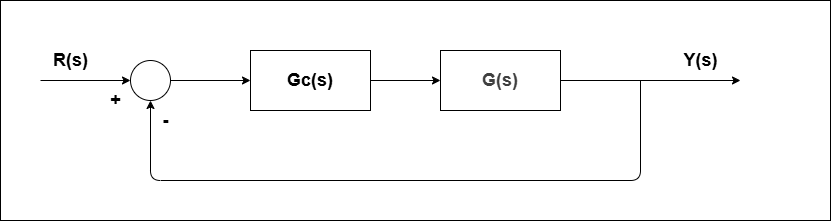

In [24]:
Image(filename='figs/diagrama_de_blocos.drawio.png')

### Resposta ao degrau unitário

#### a) Função da transferência da tensão do estator para velocidade

A partir das equações usadas para descrever o motor e considerando condições iniciais nulas é possível obter a seguinte função de transferência:

$$
G(s) = \frac{\Omega(s)}{V_i(s)} = \frac{K_t}{s^2[L_a(J + J_L)] + s[L_a(b + b_L) + R_a(J + J_L)] + [R_a(b + b_L) + K_eK_t]}
$$

In [25]:
coef_num_1 = [Kt]
coef_denom_1 = [La*(J + Jl), La*(b + bl) + La*(J + Jl), La*(b + bl) + Ke*Kt]

print("Coeficientes do numerador: ", coef_num_1)
print("Coeficientes do denominador: ", coef_denom_1)

Coeficientes do numerador:  [0.23077]
Coeficientes do denominador:  [0.0485628, 0.07272980000000001, 0.025451881206]


Por fim, a resposta ao degrau unitária desse sistema é apresentada na figura 1


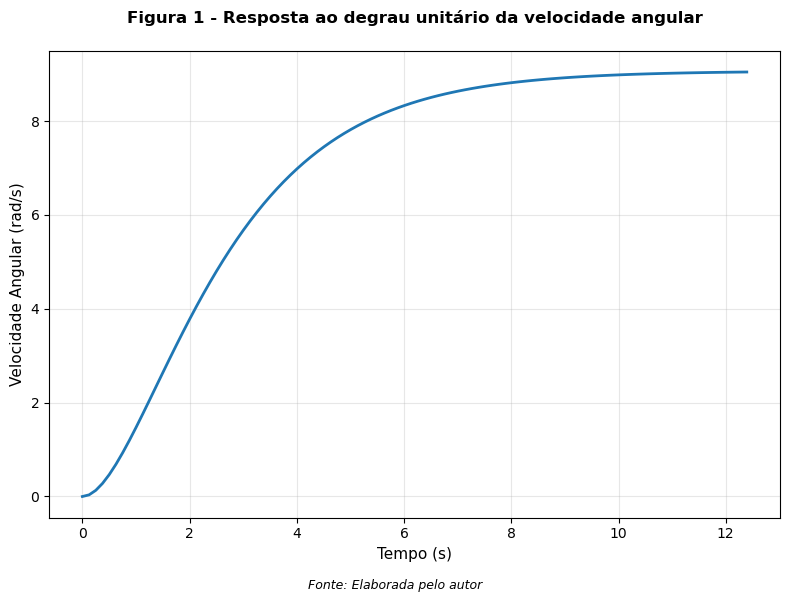

In [26]:
G_1 = ct.tf(coef_num_1, coef_denom_1)
# print("Função de transferência G(s):")
# print(G)
t, y =  ct.step_response(G_1)
print_graph(t, y, "Resposta ao degrau unitário da velocidade angular", "Tempo (s)", "Velocidade Angular (rad/s)")

#### b) Função do torque de carga para velocidade

A partir das equações usadas para descrever o motor e considerando condições iniciais nulas é possível obter a seguinte função de transferência:

$$
G(s) = \frac{\Omega(s)}{\tau_i(s)} = \frac{1}{s J_a + bl}
$$

In [27]:
coef_num_2 = [1]
coef_denom_2 = [Jl, bl]

print("Coeficientes do numerador: ", coef_num_2)
print("Coeficientes do denominador: ", coef_denom_2)

Coeficientes do numerador:  [1]
Coeficientes do denominador:  [0.036056, 0.0169]


Por fim, a resposta ao degrau unitária desse sistema é apresentada na figura 2


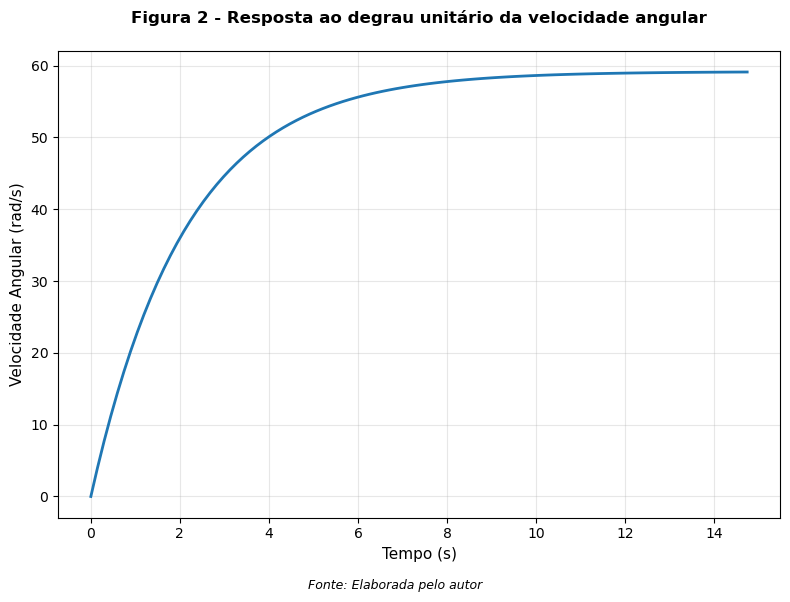

In [28]:
G_2 = ct.tf(coef_num_2, coef_denom_2)
# print("Função de transferência G(s):")
# print(G)
t, y = ct.step_response(G_2)
print_graph(t, y, "Resposta ao degrau unitário da velocidade angular", "Tempo (s)", "Velocidade Angular (rad/s)", 2)

### Análise dos resultados

## 2. Representação em espaços de estados

Inicialmente para representar o sistema em espaços de estados, é necessário definir as variáveis de estado. Analisando as equações que descrevem o motor, fica claro que a corrente de armadura $i_a(t)$ e a velocidade angular $\omega(t)$ estão relacionadas, mas não são interdependentes. Logo, a evolução temporal dessas variáveis descreve bem o comportamento do sistema e elas devem ser escolhidas como variáveis de estado.

O sistema apresenta duas entradas, a tensão do estator $V_t(t)$ e o torque de carga $\tau_L(t)$. A saída do sistema é a velocidade angular $\omega(t)$. Logo, escrevendo as equações do motor em termos das entradas e saídas, temos:

$$
\left\{
\begin{aligned}
\frac{di_a(t)}{dt} &= -(R_a/L_a)i_a(t) - (K_e/L_a)\omega(t) + (1/L_a)V_t \\
\frac{d\omega(t)}{dt} &= (K_T/J)i_a(t) - (b/J)\omega(t) - (1/J)\tau_L(t) \\
y(t) &= \omega(t)
\end{aligned}
\right.
$$

Colocando essas equações na forma matricial, obtemos a representação em espaços de estados do sistema:

$$
\begin{cases}
\dot{\vec{x}}(t) = \mathbf{A}\vec{x}(t) + \mathbf{B}\vec{u}(t) \\
\vec{y}(t) = \mathbf{C}\vec{x}(t) + \mathbf{D}\vec{u}(t)
\end{cases}
$$

$$
\begin{cases}
\begin{bmatrix}
\frac{di_a(t)}{dt} \\
\\
\frac{d\omega(t)}{dt}
\end{bmatrix}
=
\begin{bmatrix}
-\frac{R_a}{L_a} & -\frac{K_e}{L_a} \\
\\
\frac{K_T}{J} & -\frac{b}{J}
\end{bmatrix}
\begin{bmatrix}
i_a(t) \\
\\
\omega(t)
\end{bmatrix}
+
\begin{bmatrix}
\frac{1}{L_a} & 0 \\
\\
0 & -\frac{1}{J}
\end{bmatrix}
\begin{bmatrix}
V_t(t) \\
\\
\tau_L(t)
\end{bmatrix}
\\
\\
y(t) =
\begin{bmatrix}
0 & 1
\end{bmatrix}
\begin{bmatrix}
i_a(t) \\
\\
\omega(t)
\end{bmatrix}
+
\begin{bmatrix}
0 & 0
\end{bmatrix}
\begin{bmatrix}
V_t(t) \\
\\
\tau_L(t)
\end{bmatrix}
\end{cases}
$$






Em seguida, serão analisados os polos e zeros do sistema representado em espaços de estados. Os polos do sistema são os autovalores da matriz A, tomando o caso contínuo podemos calcular os polos como:

$$
det(\nu \bold{I} - \bold{A}) = 0
$$

In [29]:
# Definir matrizes
A = np.array([
    [-Ra/La, -Ke/La],
    [Kt/J,     -b/J]])
B = np.array([
    [1/La, 0],
    [0, -1/J]])
C = np.array([[0, 1]])
D = np.array([[0, 0]])
# Criar o objeto state space
state_space = ct.ss(A, B, C, D)

polos = ct.poles(state_space)
print(f"Polos do sistema: {polos}")


Polos do sistema: [-1.41923077+0.86375272j -1.41923077-0.86375272j]


Os zeros podem ser encontrados através da seguinte equação:

$$
\bold{C} \cdot \text{adj}(\nu \bold{I} - \bold{A}) \cdot \bold{B} = 0
$$

In [30]:
zeros = ct.zeros(state_space)
print(f"Zeros do sistema: {zeros}")

Zeros do sistema: []


Logo, com esses resultados pode-se plotar o mapa de polos e zeros do sistema.


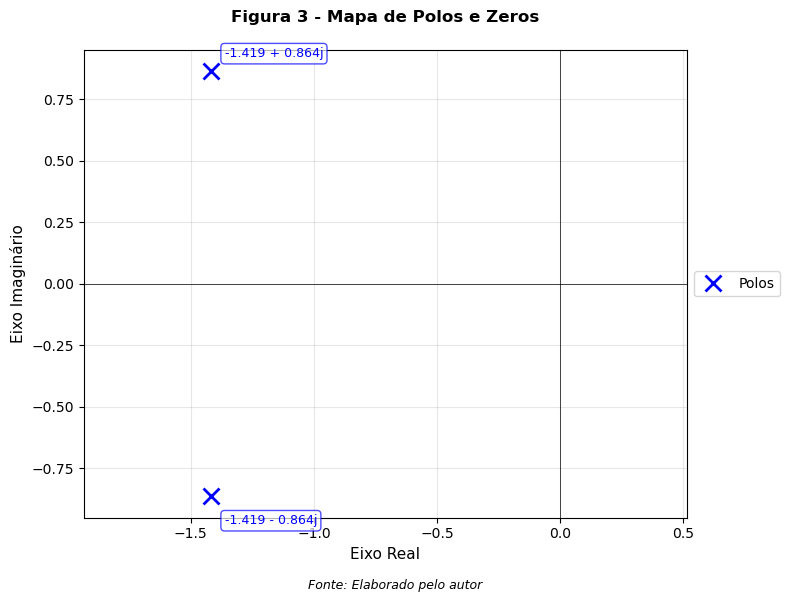

In [47]:
print_pzmap(state_space, fig_number=3)

A partir da análise do sistema, obteve-se dos polos em malha aberta, localizados em $s = -1.42 \pm 0,86j$, e nenhum zero. Logo, o sistema é estável, pois a parte real de ambos os polos é negativa, situando-se no semiplano esquerdo. Além disso, como os polos são complexos conjugados, o sistema é classificado como sub-amortecido. Isso implica que sua resposta transitória natural apresentará oscilaÇões antes de atingir o estado estacionário.  

## 3. Discretização do sistema 

Utilizando a seguinte a aproximação para a derivada e substituindo na definição de espaço de estado para sistemas contínuos, obtêm-se.

$$
\dot{x}(t) \approx \frac{x[k+1] - x[k]}{T_s}
$$

$$
\begin{cases}
\vec{x}[k+1] = \mathbf{A}_d\vec{x}[k] + \mathbf{B}_d\vec{u}[k] \\
\vec{y}[k] = \mathbf{C}_d\vec{x}[k] + \mathbf{D}_d\vec{u}[k]
\end{cases}
$$

Onde:

- $\mathbf{A}_d = T_s \mathbf{A} + \mathbf{I}$
- $\mathbf{B}_d = T_s \mathbf{B}$
- $\mathbf{C}_d = \mathbf{C}$
- $\mathbf{D}_d = \mathbf{D}$

Logo, o sistema em análise pode ser discretizado como:

$$
\begin{cases}
\begin{bmatrix}
i_a[k+1] \\
\\
\omega[k+1]
\end{bmatrix}
=
\begin{bmatrix}
1 - \frac{T_s R_a}{L_a} & -\frac{T_s K_e}{L_a} \\
\\
\frac{T_s K_T}{J} & 1 - \frac{T_s b}{J}
\end{bmatrix}
\begin{bmatrix}
i_a[k] \\
\\
\omega[k]
\end{bmatrix}
+
\begin{bmatrix}
\frac{T_s}{L_a} & 0 \\
\\
0 & -\frac{T_s}{J}
\end{bmatrix}
\begin{bmatrix}
V_t[k] \\
\\
\tau_L[k]
\end{bmatrix}
\\
\\
y[k] =
\begin{bmatrix}
0 & 1
\end{bmatrix}
\begin{bmatrix}
i_a[k] \\
\\
\omega[k]
\end{bmatrix}
+
\begin{bmatrix}
0 & 0
\end{bmatrix}
\begin{bmatrix}
V_t[k] \\
\\
\tau_L[k]
\end{bmatrix}
\end{cases}
$$

Para a análise numérica do sistema foi utilizado o método ZOH visto que é mais preciso que o método anterior e tem menos chance de levar o sistema a instabilidade. Adotando um tempo de amostragem de $T_s = 0.001$, obtém-se:

Matriz Ad discreta:
[[ 9.98462342e-01 -4.27684840e-06]
 [ 1.77263606e-01  9.98700465e-01]]

Matriz Bd discreta:
[[ 7.68639259e-04  1.64572025e-06]
 [ 6.82105793e-05 -7.68730888e-01]]

Matriz Cd discreta:
[[0. 1.]]

Matriz Dd discreta:
[[0. 0.]]



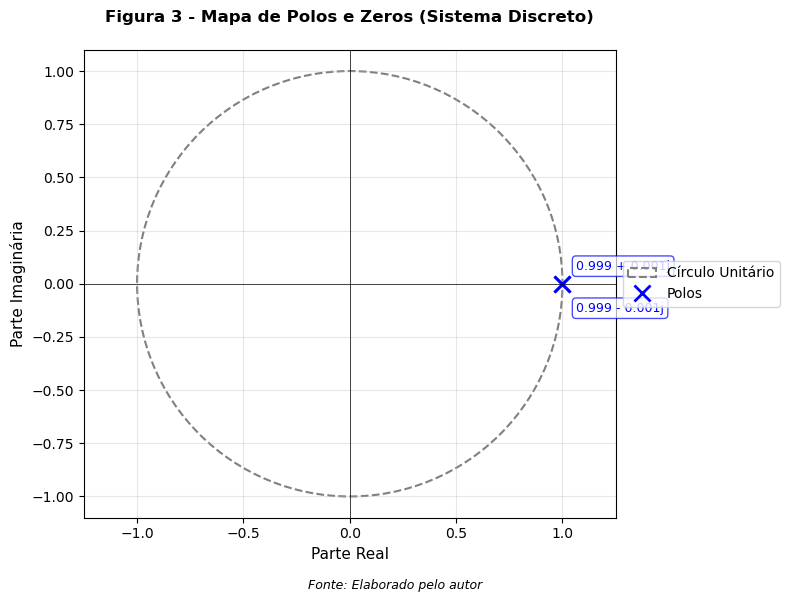

In [48]:
# Tempo de amostragem 
Ts = 0.001 

sistema_discreto = state_space.sample(Ts, method='zoh')

print("Matriz Ad discreta:")
print(sistema_discreto.A)

print("\nMatriz Bd discreta:")
print(sistema_discreto.B)

print("\nMatriz Cd discreta:")
print(sistema_discreto.C)

print("\nMatriz Dd discreta:")
print(sistema_discreto.D)

print_pzmap(sistema_discreto)

